In [57]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Load the cleaned dataset
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Filter out cancelled transactions
df['IsCancelled'] = df['CancellationFlag'].notnull() & (df['CancellationFlag'].astype(str).str.strip() != '')
df_clean = df[~df['IsCancelled']]

customer_df = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',       # Frequency
    'Subtotal': 'sum',            # Monetary
    'InvoiceDate': 'max'          # Last purchase date
}).rename(columns={
    'InvoiceNo': 'Frequency',
    'Subtotal': 'Monetary',
    'InvoiceDate': 'LastPurchase'
})

customer_df['is_loyal'] = ((customer_df['Frequency'] > 10) & (customer_df['Monetary'] > 1000)).astype(int)

# Recency: days since last purchase
latest_date = df_clean['InvoiceDate'].max()
customer_df['Recency'] = (latest_date - customer_df['LastPurchase']).dt.days
customer_df.drop(columns='LastPurchase', inplace=True)

scaler = StandardScaler()
X = customer_df[['Recency', 'Frequency', 'Monetary']]
X_scaled = scaler.fit_transform(X)  
y = customer_df['is_loyal']

kmeans = KMeans(n_clusters=3, random_state=4)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=4)

# Train model
clf = RandomForestClassifier(random_state=4)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1001
           1       1.00      1.00      1.00        82

    accuracy                           1.00      1083
   macro avg       1.00      1.00      1.00      1083
weighted avg       1.00      1.00      1.00      1083



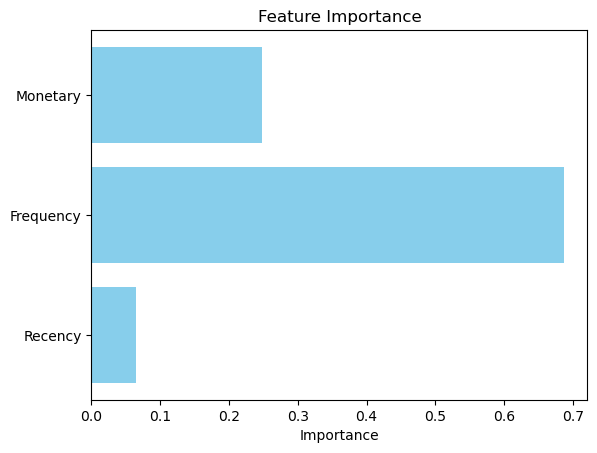

In [58]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
features = X.columns

plt.barh(features, importances, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

In [61]:
# Score a batch of new customers
new_customers = pd.DataFrame([
    {'Recency': 10, 'Frequency': 17, 'Monetary': 1800},
    {'Recency': 200, 'Frequency': 3, 'Monetary': 150}
])

# Use the original scaler (already fitted)
new_scaled = scaler.transform(new_customers[['Recency', 'Frequency', 'Monetary']])

# Predict loyalty
predictions = clf.predict(new_scaled)
print("Predicted loyalty:", predictions)



Predicted loyalty: [1 0]


In [62]:
pd.crosstab(customer_df['Cluster'], customer_df['is_loyal'])

is_loyal,0,1
Cluster,,
0,2931,324
1,0,1
2,1070,4


In [63]:
loyal_customers = customer_df[customer_df['is_loyal'] == 1]
display(loyal_customers)

,Frequency,Monetary,is_loyal,Recency,Cluster
CustomerID,,,,,
12395,12,3018.63,1,18,0
12415,20,124755.88,1,23,0
12431,15,6487.45,1,35,0
12437,18,4951.41,1,1,0
12471,30,19824.05,1,1,0
...,...,...,...,...,...
18229,20,7276.90,1,11,0
18241,17,2073.09,1,9,0
18283,16,2094.88,1,3,0


In [64]:
loyal_summary = loyal_customers[['Recency', 'Frequency', 'Monetary']].describe()
print(loyal_summary)


          Recency    Frequency      Monetary
count  329.000000   329.000000  3.290000e+02
mean    15.042553    25.313070  1.823320e+04
std     30.718698    76.576455  9.666412e+04
min      0.000000    11.000000  1.296440e+03
25%      2.000000    12.000000  3.901810e+03
50%      7.000000    15.000000  5.719820e+03
75%     18.000000    22.000000  1.046485e+04
max    371.000000  1363.000000  1.691524e+06
